In [5]:

%matplotlib inline

import sys, platform, os
sys.path.append('/Users/azadeh/Desktop/IR_resummation/codes/Azadeh/EUCLID/scripts/')
import EH_fit as EH
import broadband_extraction as broadband_ben
import wiggle_nowiggle_BSpline as wnw_BSpline
import wiggle_nowiggle_Gfilter as wnw_Gfilter

from timeit import default_timer as timer
import sys, platform, os
import scipy.fftpack as fft
from scipy.interpolate import interp1d,splev,splrep, InterpolatedUnivariateSpline
from matplotlib import pyplot as plt
import numpy as np

### scipy functions to find local minima and maxima of data
from scipy.signal import argrelmin
from scipy.signal import argrelmax
from scipy.signal import find_peaks_cwt
from scipy.signal import gaussian
from scipy.signal import convolve

#sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from classy import Class
import camb
from camb import model, initialpower, reionization
print('CAMB version: %s '%camb.__version__)

plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = [6, 4]

plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams["axes.labelsize"] = 16
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.minor.width'] = 0.6
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'on'
plt.rcParams['ytick.right'] = 'on'

CAMB version: 1.1.0 


In [6]:
pars = camb.CAMBparams();
pars.set_cosmology(H0=67., ombh2=0.0219961, omch2=0.121203, omk = 0., TCMB= 2.726, YHe = 0.24, num_massive_neutrinos=0, mnu = 0,nnu=3.04,  tau = 0.1003);
pars.InitPower.set_params(As=2.110651747790177e-9, ns=0.96, r=0, pivot_scalar = 0.05);
pars.set_matter_power(redshifts=[0.,10.0], kmax=500.);
pars.set_accuracy(AccuracyBoost=3.0, lSampleBoost=1.0, lAccuracyBoost=3.0)
pars.Reion.get_zre(pars,tau=None)


Note: redshifts have been re-sorted (earliest first)


12.003423919258314

In [7]:
##### test sigma8
results = camb.get_results(pars)
s8 = np.array(results.get_sigma8())
print s8

[0.0956395  0.82992976]


1. Compare the matter power spectrum from class and camb

1.1. Compute the theoretical matter power spectrum: calling the power spectrum interpolator from camb

In [8]:
PK_NL = camb.get_matter_power_interpolator(pars, nonlinear=True,hubble_units=True,k_hunit=True,zmax=1100,log_interp=True,k_per_logint=True)
PK_L = camb.get_matter_power_interpolator(pars, nonlinear=False,hubble_units=True,k_hunit=True,zmax=1100,log_interp=True,k_per_logint=True)

1.2. Compute the matter power spectrum with class

In [9]:
# logk = np.linspace(-4.,2.,5000)
# ks = (10.**logk)

params = {
    'output': 'mPk',
    'A_s': 2.110651747790177e-9,
    'n_s': 0.96,
    'h': 0.67,
    'omega_b': 0.0219961,
    'omega_cdm': 0.121203,
    'tau_reio': 0.0999,
    'P_k_max_h/Mpc':1000.,
    'k_pivot': 0.05,
    'Omega_k':0.,
    'T_cmb': 2.726,
    'YHe': 0.24,
    'N_ur': 3.04,
    'N_ncdm':0
} 

cosmo = Class()
cosmo.set(params)
cosmo.compute()

# PkClass = []
# for k in ks :
#         PkClass.append(cosmo.pk(k ,0.) )

# cosmo.struct_cleanup()
# cosmo.empty()


1.3. load the matter power spectrum from a file and build an interpolator in logspace

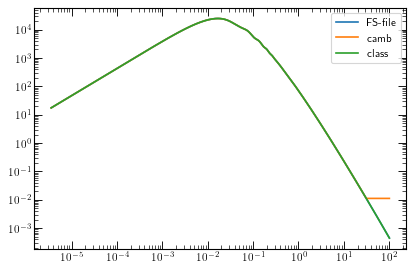

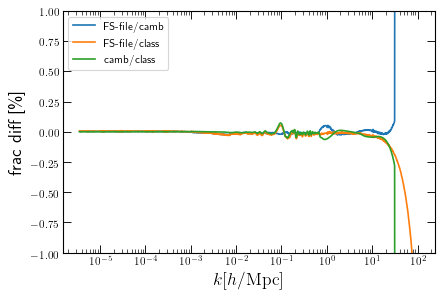

In [12]:
ka, pka       = np.loadtxt('/Volumes/Data/Documents/Git/gc-wp-nonlinear/linear_spectra_flagship/matter/high_res/flagship_linear_cb_hr_matterpower_z0p0.dat',unpack=True)
logpka        = np.log10(pka)
logka         = np.log10(ka)
logpka_interp = InterpolatedUnivariateSpline(logka,logpka,k=3)

def pk_interp(k):
    logk = np.log10(k)
    return 10.**logpka_interp(logk)

PkClass = []
for k in ka :
    PkClass.append(cosmo.pk(k*0.67,0.)*(0.67**3.))

        
plt.loglog(ka,pk_interp(ka),label ='FS-file')
plt.loglog(ka,PK_L.P(0,ka),label ='camb')
plt.loglog(ka,PkClass,label= 'class')
plt.legend()
plt.show()

plt.semilogx(ka,(PK_L.P(0,ka)/pk_interp(ka)-1.)*100.,label ='FS-file/camb')
plt.semilogx(ka,(PkClass/pk_interp(ka)-1.)*100.,label ='FS-file/class')
plt.semilogx(ka,(PkClass/PK_L.P(0,ka)-1.)*100.,label ='camb/class')
plt.ylim(-1,1)
plt.ylabel("frac diff [\%]")
plt.xlabel("$k [h/\mathrm{Mpc}]$")
plt.legend()
plt.show()


2 - Sample $\log(kP(k))$ in $2^n$ points for an integer number $n$. These points are chosen equidistant in $k$.

In [164]:
### The numer of points and sample spacing, as well as kmax, should be chosen 
### such that the sine transform of the PS does not show ringing bbehavior

N  = 2**16   #number of sample points  
T = 0.005

kmin=1.e-4
kmax = 10.
#kmax = N*T/16
k = np.linspace(kmin,kmax,N)
logk = np.log10(k)
grid = np.log10(k*PK_L.P(0,k))
# grid = np.log10(k*pk_interp(k))

# PkClass = []
# for k1 in k :
#     PkClass.append(cosmo.pk(k1 ,0.) )

# grid = np.log10(k*PkClass)




3 - Perform a fast sine transform of the $\log(kP(k))$-array using the orthonomralized type-II sine transform. Denoting the index of the resulting array by $i$, split the even and off entries. i.e. those entries with even $i$ and odd $i$, into separate arrays.

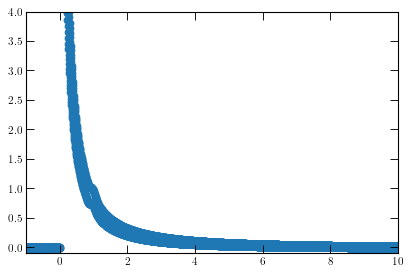

In [165]:
grid_sine = fft.dst(grid, type=2, norm="ortho")
grid_freqs = fft.fftfreq(grid_sine.shape[0],d=T)

plt.scatter(np.fft.fftshift(grid_freqs),np.fft.fftshift(grid_sine))
plt.xlim(-1,10.)
plt.ylim(-.1,4.)
plt.show()

Checking that I recover the original power spectrum when doing the inverse sine transform: (Note that the IDST of type 2 is the same as DST pf type 3, so one can use  fft.idst(grid_sine, type=2, norm='ortho') or fft.dst(grid_sine, type=3, norm='ortho') 

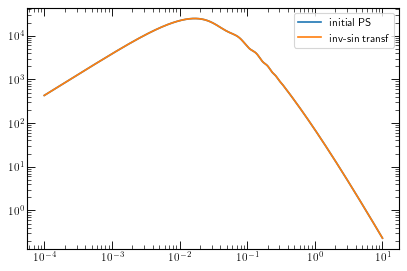

In [166]:
grid_logkpk = fft.idst(grid_sine, type=2, norm="ortho")  

kpk_grid = 10.**(grid_logkpk)
pk_grid = kpk_grid/k

plt.loglog(k,PK_L.P(0,k),label="initial PS")
plt.loglog(k,pk_grid, label= "inv-sin transf")
plt.legend()
plt.show()


Success!

In [167]:
even_ind = []
even_freq = []
odd_ind = []
odd_freq = []

even_ind  = grid_sine[0:len(grid_sine):2]
even_freq = grid_freqs[0:len(grid_freqs):2]
odd_ind   = grid_sine[1:len(grid_sine):2]
odd_freq  = grid_freqs[1:len(grid_freqs):2]


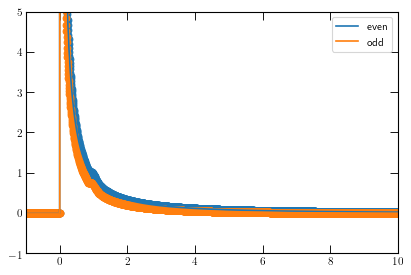

In [168]:
plt.scatter(even_freq,even_ind)
plt.scatter(odd_freq,odd_ind)
plt.plot(np.fft.fftshift(even_freq),np.fft.fftshift(even_ind),label="even")
plt.plot(np.fft.fftshift(odd_freq),np.fft.fftshift(odd_ind),label="odd")
plt.xlim(-1,10.)
plt.ylim(-1,5.)
plt.legend()
plt.show()

In [169]:
even_freq = np.fft.fftshift(even_freq)
even_ind = np.fft.fftshift(even_ind)
odd_freq = np.fft.fftshift(odd_freq)
odd_ind =  np.fft.fftshift(odd_ind)

4 - Linearly interpolate the two arrays separately using cubic splines.

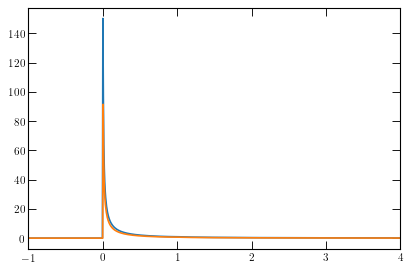

In [170]:
even = splrep(even_freq, even_ind,s=0)
odd = splrep(odd_freq,odd_ind,s=0)

even_new = splev(even_freq, even, der=0)
odd_new = splev(odd_freq, odd, der=0)


### In the plot bbelow, I have zoomed in to see the BAO signal more clearly 
### so that we can understand which array elements shoudl be removed
plt.plot(even_freq,even_new)
plt.plot(odd_freq,odd_new)
plt.xlim(-1,4)
# plt.ylim(-.1,3.)
plt.show()

5 - Identify baryonic bumps by computing the second derivatie separately for the interpolated even and odd arrays. 

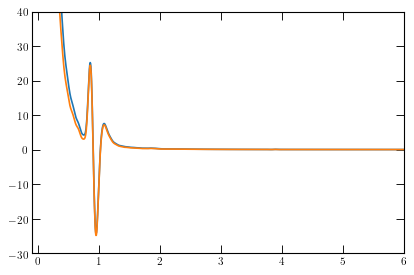

In [171]:
second_der_even = splev(even_freq, even, der=2)
second_der_odd = splev(odd_freq, odd, der=2)


### Since the BAO signal is on the positive frequencies, I am limiting the range of frequencies to check for 
### the extrema of the second derivative. Otherwise it extrema finder will pick out numerical noise around 
### zero frequency. There is perhaps a better way of doing this. 

even_freq_pos = np.ndarray.flatten(np.argwhere(even_freq>.1))[0]
odd_freq_pos = np.ndarray.flatten(np.argwhere(odd_freq>.1))[0]
# print even_freq_pos, odd_freq_pos
# print second_der_even[even_freq_pos], second_der_odd[odd_freq_pos]


### Build new temporary arrays of the frequencies and second derivatives which only span the frequencies > 0.1
second_der_even_n = second_der_even[even_freq_pos:]
second_der_odd_n = second_der_odd[odd_freq_pos:]
even_freq_n = even_freq[even_freq_pos:]
odd_freq_n = odd_freq[odd_freq_pos:]
# print even_freq_n, second_der_even_n 
# print odd_freq_n, second_der_odd_n 


plt.plot(even_freq_n,second_der_even_n)
plt.plot(odd_freq_n,second_der_odd_n)
plt.xlim(-.1,6.)
plt.ylim(-30,40.)
plt.show()

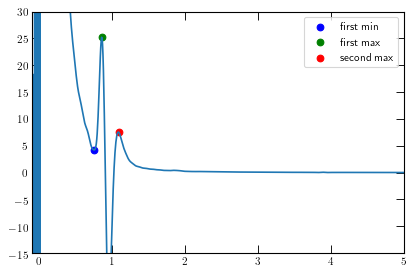

In [172]:
min_even = argrelmin(second_der_even_n,order=10)
max_even = argrelmax(second_der_even_n,order=10)

first_min_ind_even = [min_even[0][0]]
second_min_ind_even = [min_even[0][1]]
first_max_ind_even = [max_even[0][0]]
second_max_ind_even = [max_even[0][1]]

# print even_freq_n[0], even_freq_n[1]
# print first_max_ind_even, second_max_ind_even
# print even_freq_n[max_even[0][0]], second_der_even_n[max_even[0][0]]
# print even_freq_n[max_even[0][1]], second_der_even_n[max_even[0][1]]

# print first_min_ind_even, second_min_ind_even
# print even_freq_n[min_even[0][0]], second_der_even_n[min_even[0][0]]
# print even_freq_n[min_even[0][1]], second_der_even_n[min_even[0][1]]

plt.plot(even_freq,second_der_even)
plt.scatter(even_freq_n[min_even[0][0]],second_der_even_n[min_even[0][0]],color='b',label='first min')
plt.scatter(even_freq_n[max_even[0][0]],second_der_even_n[max_even[0][0]],color='g',label='first max')
plt.scatter(even_freq_n[max_even[0][1]],second_der_even_n[max_even[0][1]],color='r',label='second max')
plt.xlim(-.1,5.)
plt.ylim(-15,30.)
# plt.ylim(-8000,10000)
plt.legend()
plt.show()



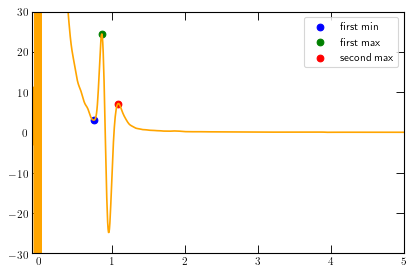

In [173]:
min_odd = argrelmin(second_der_odd_n,order=10)
max_odd = argrelmax(second_der_odd_n,order=10)

first_min_ind_odd = [min_odd[0][0]]
second_min_ind_odd = [min_odd[0][1]]
first_max_ind_odd = [max_odd[0][0]]
second_max_ind_odd = [max_odd[0][1]]
   
plt.plot(odd_freq,second_der_odd,color='orange')
plt.scatter(odd_freq_n[min_odd[0][0]],second_der_odd_n[min_odd[0][0]],color='b',label='first min')
plt.scatter(odd_freq_n[max_odd[0][0]],second_der_odd_n[max_odd[0][0]],color='g',label='first max')
plt.scatter(odd_freq_n[max_odd[0][1]],second_der_odd_n[max_odd[0][1]],color='r',label='second max')
plt.xlim(-.1,5.)
plt.ylim(-30.,30.)
plt.legend()
plt.show()

Sine we need the full array of the sine transform and not only the part of it we used to find the BAO signal, now 
we add back the indecies of the part of the array for frequencies of <0.1. Then remove the array elements to the 
right and left that would remove the BAO signal. This is thebest choice I could find to get the relatively clean broadband. The values in Baumann et al did not work. 

In [174]:
i_min_even = even_freq_pos+first_min_ind_even[0]-2
i_min_odd = odd_freq_pos+first_min_ind_odd[0]-2
i_max_even = even_freq_pos+second_max_ind_even[0] + 20
i_max_odd = even_freq_pos+ second_max_ind_odd[0] + 20

# i_min_even = even_freq_pos+first_min_ind_even[0]-7
# i_min_odd = odd_freq_pos+first_min_ind_odd[0]-7
# i_max_even = even_freq_pos+second_max_ind_even[0] + 20
# i_max_odd = even_freq_pos+ second_max_ind_odd[0] + 19

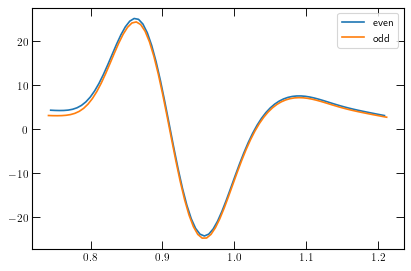

In [175]:
plt.plot(even_freq[i_min_even:i_max_even],second_der_even[i_min_even:i_max_even],label="even")
plt.plot(odd_freq[i_min_odd:i_max_odd],second_der_odd[i_min_odd:i_max_odd],label="odd")
plt.legend()
plt.show()

###### 6 - Cut baryonic bumps: remove the elements within the range $[i_{min},i_{max}]$.

In [176]:
x1e = even_freq[:i_min_even]
x2e = even_freq[i_max_even:]

part1_even = even_new[:i_min_even]
part2_even = even_new[i_max_even:]

x1o = odd_freq[:i_min_odd]
x2o = odd_freq[i_max_odd:]

part1_odd = odd_new[:i_min_odd]
part2_odd = odd_new[i_max_odd:]

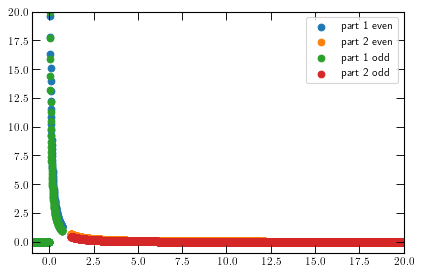

In [177]:
plt.scatter(x1e,part1_even,label='part 1 even')
plt.scatter(x2e,part2_even,label='part 2 even')
plt.scatter(x1o,part1_odd,label='part 1 odd')
plt.scatter(x2o,part2_odd,label='part 2 odd')
plt.xlim(-1.,20.)
plt.ylim(-1.,20.)
plt.legend()
plt.show()

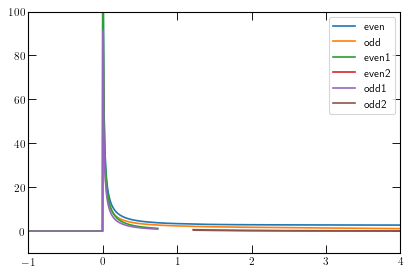

In [178]:
freq_cute = np.append(x1e,x2e)
even_cut = np.append(part1_even,part2_even)

freq_cuto = np.append(x1o,x2o)
odd_cut = np.append(part1_odd,part2_odd)

ind_arr_e = np.arange(0,len(even_cut),1)
ind_arr_o = np.arange(0,len(odd_cut),1)

### REscaling suggested to reduce the noise
even_cut_resc = (freq_cute + 1.)**2. * even_cut
odd_cut_resc  = (freq_cuto + 1.)**2. * odd_cut


even_resc = splrep(freq_cute, even_cut_resc, s=0,k=3)
odd_resc  = splrep(freq_cuto, odd_cut_resc, s=0,k=3)

freqe = np.linspace(min(freq_cute),max(freq_cute),N/2)
freqo = np.linspace(min(freq_cuto),max(freq_cuto),N/2)

even_interp = splev(freqe, even_resc, der=0)
odd_interp  = splev(freqo, odd_resc, der=0)

plt.plot(freqe,even_interp,label='even')
plt.plot(freqo,odd_interp,label='odd')
plt.plot(x1e,part1_even,label="even1")
plt.plot(x2e,part2_even,label="even2")
plt.plot(x1o,part1_odd,label="odd1")
plt.plot(x2o,part2_odd,label="odd2")
plt.xlim(-1.,4.)
plt.ylim(-10.,100.)
plt.legend()
plt.show()

In [179]:
ind_arr_e = np.arange(0,len(freqe),1)
ind_arr_o = np.arange(0,len(freqo),1)

even_interp_N = even_interp/(freqe+1.)**2.
odd_interp_N = odd_interp/(freqo+1.)**2.

freq_tot = np.append(freqe,freqo)
array_tot = np.append(even_interp_N,odd_interp_N)

ind = np.argsort(freq_tot)
freq_tot_sort = freq_tot[ind]
array_tot_sort = array_tot[ind]

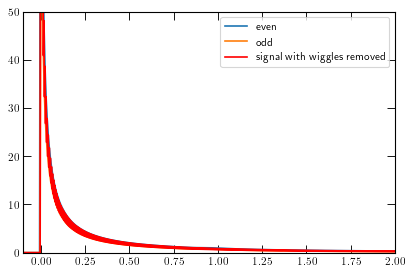

In [180]:
plt.plot(freqe,even_new,label='even')
plt.plot(freqo,odd_new,label='odd')
plt.plot(freq_tot_sort,array_tot_sort,color='r',label='signal with wiggles removed')
plt.xlim(-.1,2.)
plt.ylim(-.1,50)
plt.legend()
plt.show()

7 - Inverse fast sine transform, leading to a discretized version of $\log[k \; P^{\rm nw}(k)]$.

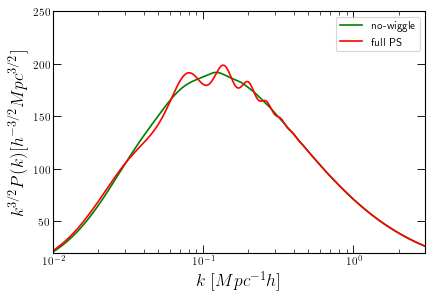

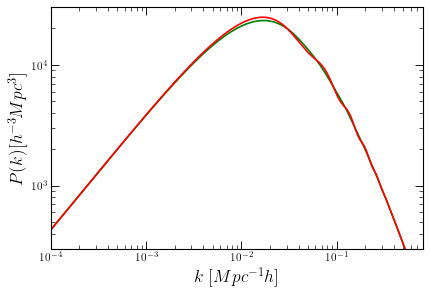

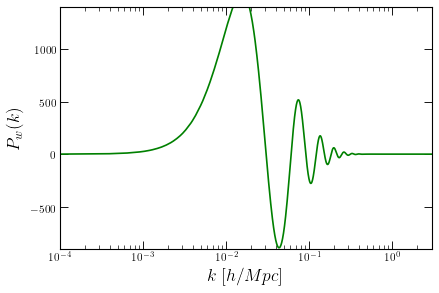

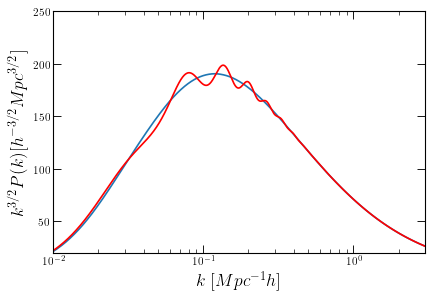

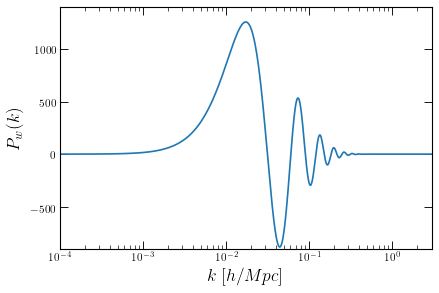

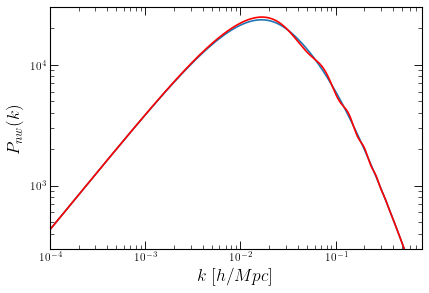

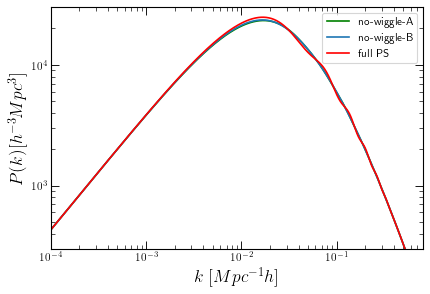

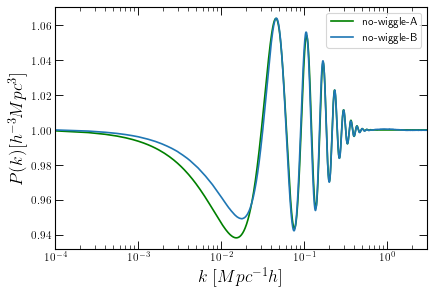

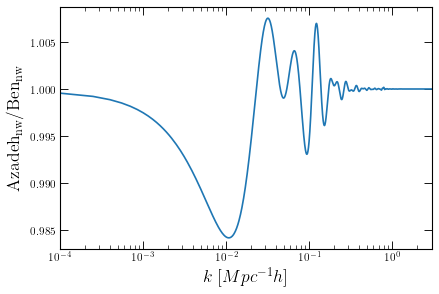

In [182]:
### Note that dst of type 3 is equal to idst of type 2
logks = np.linspace(-4.,1.,5000)
ks = (10.**logks)  ##ks in units of h/Mpc

logkpk_grid = fft.dst(np.fft.fftshift(array_tot_sort), type=3, norm= "ortho")
kpk_grid = 10.**(logkpk_grid)
pk_grid = kpk_grid/k

pk_nw_interp = InterpolatedUnivariateSpline(k,pk_grid,k=3)
#pk_w = PK_L.P(0,ks) - pk_nw_interp(ks)
pk_w = pk_interp(ks) - pk_nw_interp(ks)


plt.semilogx(ks,ks**(3./2.)*pk_nw_interp(ks),label="no-wiggle", color="g")
plt.semilogx(ks,ks**(3./2.)*PK_L.P(0,ks),label='full PS', color="red")
#plt.semilogx(ks,ks**(3./2.)*pk_interp(ks),label='full PS', color="red")
plt.xlim(0.01,3.)
plt.ylim(20.,250)
plt.xlabel('$k \; [Mpc^{-1} h]$')
plt.ylabel('$k^{3/2}P(k)[h^{-3/2} Mpc^{3/2}]$')
plt.legend()
plt.show()


plt.loglog(ks,pk_nw_interp(ks),label="no-wiggle",color="g")
plt.loglog(ks,PK_L.P(0,ks),label='full PS', color="red")
#plt.loglog(ks,pk_interp(ks),label='full PS', color="red")
plt.xlabel('$k \; [Mpc^{-1} h]$')
plt.ylabel('$P(k)[h^{-3} Mpc^3]$')
plt.xlim(1e-4,.8)
plt.ylim(300.,3e4)
plt.show()

plt.semilogx(ks,pk_w,'g')
plt.xlabel('$k \; [h/Mpc]$')
plt.ylabel('$P_w(k)$')
plt.xlim(1e-4,3.)
plt.ylim(-900,1400)
#plt.savefig('w.png')
plt.show()

k_range, pk_array, pknw_array, pkw_array, k_splits = broadband_ben.broadband_extraction(k_range=k, pk_array=PK_L.P(0,k), points=15, k_max_extr=1.)
#k_range, pk_array, pknw_array, pkw_array, k_splits = broadband_ben.broadband_extraction(k_range=k, pk_array=pk_interp(k), points=15, k_max_extr=1.)
plt.semilogx(k_range, k_range**(3./2.)*pknw_array)
plt.semilogx(k_range,k_range**(3./2.)*PK_L.P(0,k_range),'red')
#plt.semilogx(k_range,k_range**(3./2.)*pk_interp(k_range),'red')
plt.xlabel('$k \; [Mpc^{-1} h]$')
plt.ylabel('$k^{3/2}P(k)[h^{-3/2} Mpc^{3/2}]$')
plt.xlim(0.01,3.)
plt.ylim(20.,250)
plt.show()

plt.semilogx(k_range,pkw_array)
plt.xlabel('$k \; [h/Mpc]$')
plt.ylabel('$P_w(k)$')
plt.xlim(1e-4,3.)
plt.ylim(-900,1400)
#plt.savefig('w.png')
plt.show()

plt.loglog(k_range,pknw_array,label="no-wiggle")
plt.loglog(ks,PK_L.P(0,ks),label='full PS', color="red")
#plt.loglog(ks,pk_interp(ks),label='full PS', color="red")
plt.xlabel('$k \; [h/Mpc]$')
plt.ylabel('$P_{nw}(k)$')
plt.xlim(1e-4,.8)
plt.ylim(300.,3e4)
#plt.savefig('nw.png')
plt.show()

plt.loglog(k_range,pk_nw_interp(k_range),label="no-wiggle-A", color="g")
plt.loglog(k_range,pknw_array,label="no-wiggle-B")
plt.loglog(k_range,PK_L.P(0,k_range),label='full PS', color="red")
#plt.loglog(k_range,pk_interp(k_range),label='full PS', color="red")
plt.xlabel('$k \; [Mpc^{-1} h]$')
plt.ylabel('$P(k)[h^{-3} Mpc^3]$')
plt.xlim(1e-4,.8)
plt.ylim(300.,3e4)
plt.legend()
plt.show()

#plt.semilogx(k_range,pk_nw_interp(k_range)/pk_interp(k_range),label="no-wiggle-A", color="g")
plt.semilogx(k_range,pk_nw_interp(k_range)/PK_L.P(0,k_range),label="no-wiggle-A", color="g")
plt.semilogx(k_range,pknw_array/pk_interp(k_range),label="no-wiggle-B")
plt.xlabel('$k \; [Mpc^{-1} h]$')
plt.ylabel('$P(k)[h^{-3} Mpc^3]$')
plt.legend()
plt.xlim(1e-4,3.)
plt.show()

plt.semilogx(k_range,pk_nw_interp(k_range)/pknw_array )
plt.xlabel('$k \; [Mpc^{-1} h]$')
plt.ylabel('$\mathrm{Azadeh}_\mathrm{nw}/\mathrm{Ben}_\mathrm{nw}$')
plt.xlim(1e-4,3.)
plt.show()

Showing that we recover the original signal if we don't cut out parts of the arrays:

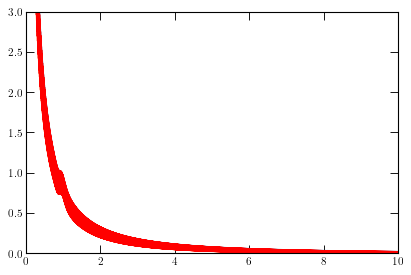

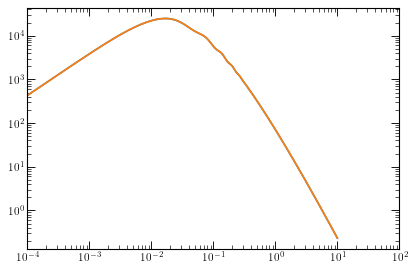

In [183]:
freq_tot = np.append(freqe,freqo)
array_tot = np.append(even_new,odd_new)

ind = np.argsort(freq_tot)
freq_tot = freq_tot[ind]
array_tot_sort = array_tot[ind]

plt.plot(freqe,even_new,label='even')
plt.plot(freqo,odd_new,label='odd')
plt.plot(freq_tot,array_tot_sort,color='r',label='signal with wiggles removed')
plt.xlim(0,10)
plt.ylim(0,3)
plt.show()

ind = np.argsort(freq_tot)
freq_tot = freq_tot[ind]

logkpk_grid = fft.dst(np.fft.fftshift(array_tot_sort), type=3, norm='ortho')
kpk_grid = 10**logkpk_grid
pk_grid = kpk_grid/k

plt.loglog(k,PK_L.P(0,k))
plt.loglog(k,pk_grid)
plt.xlim(1e-4,100)
# plt.ylim(10,1e5)
plt.show()